# Neural Data Science Project 02

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

## Context
![image.png](output/images/vcd-task.png)

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

![image-3.png](output/images/vcd-graph.png)

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the stimulus frames
- the ROI masks for each cell
- a maximum activity projection of the recorded area
- running speed
- table of stimulus epochs

You will only work with a locally sparse noise stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [2]:
# import packages here

import numpy as np
import pandas as pd
import jupyter_black

jupyter_black.load()

In [21]:
# load data
def load_data(path="."):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_rf.npz", allow_pickle=True)
    data = dict(data)
    array2df(data, "stim_table", ["frame", "start", "end"])
    array2df(data, "stim_epoch_table", ["start", "end", "stimulus"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data()

print("Overview of the data")
print_info(data)

Overview of the data
[t] - <class 'numpy.ndarray'>, - (105968,)
[dff] - <class 'numpy.ndarray'>, - (189, 105968)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (8880, 3)
[stim] - <class 'numpy.ndarray'>, - (9000, 16, 28)
[roi_masks] - <class 'numpy.ndarray'>, - (189, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 105968)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



### What are locally sparse noise stimulus ?

**Locally Sparse**: In each frame, most of the screen is a neutral grey. Only a few, small, randomly 
chosen locations ("local") have either a black or a white square. The rest of the screen is blank ("sparse").

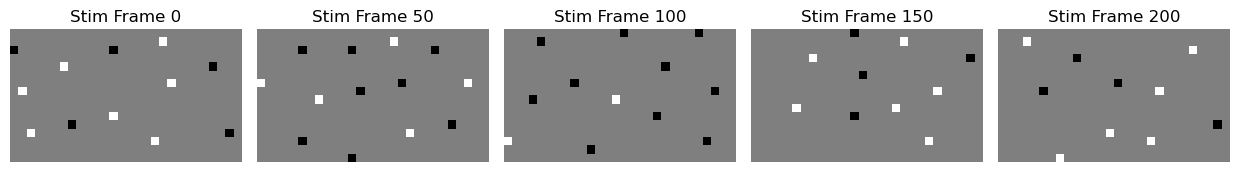

In [22]:
import utils as U
import importlib

importlib.reload(U)  # Use this if you update your utils.py file

# # First, let's look at a few static frames again for context
U.plot_stim_frames(data, indices_to_display=[0, 50, 100, 150, 200])

,start,end,stimulus
0,locally_sparse_noise,737,22461
1,spontaneous,22611,31520
2,natural_movie_one,31521,40571
3,locally_sparse_noise,41476,63199
4,natural_movie_two,64105,73156
5,spontaneous,73306,82207
6,locally_sparse_noise,82208,105742


In [23]:
# --- How to use this in your main notebook ---
# You would replace your original block of code with these function calls:

# # Assuming 'data' is already loaded...
import utils as U

importlib.reload(U)
import logging

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

# 1. Filter the time-series data (dff, t, etc.) for the correct epochs
t_filtered, dff_filtered, running_speed_filtered = U.filter_timeseries_by_epoch(
    data, stimulus_name="locally_sparse_noise"
)

Filtering time-series data for 'locally_sparse_noise' epochs...
Performing initial data preprocessing...
Preprocessing complete.
Total epochs available: 7
Epochs columns: ['stimulus', 'start_time', 'end_time']
Looking for epochs with stimulus name: locally_sparse_noise
Epochs with stimulus 'locally_sparse_noise': 3  
Time-series filtering complete.
Filtered dff shape: (189, 1760)
Filtered t shape: (1760,)


In [ ]:
# Get the min and max time of the *filtered* calcium recording
min_t_filtered = t_filtered.min()
max_t_filtered = t_filtered.max()

# Filter stim_table to include only frames whose presentation times
# overlap with the filtered calcium recording time window.
stim_table_filtered_df = data["stim_table"][
    (data["stim_table"]["start_s"] >= min_t_filtered)
    & (data["stim_table"]["start_s"] < max_t_filtered)
].copy()

# Now, use the 'frame' indices from the filtered stim_table to get 
# the actual stimulus frames from the original 'stim' array.
unique_filtered_frames_indices = stim_table_filtered_df["frame"].unique()

# Select the actual stimulus frames
stim_filtered = data["stim"][unique_filtered_frames_indices]

Filtering time-series data for 'locally_sparse_noise' epochs...
Performing initial data preprocessing...
Preprocessing complete.
Total epochs available: 7
Epochs columns: ['stimulus', 'start_time', 'end_time']
Looking for epochs with stimulus name: locally_sparse_noise
Epochs with stimulus 'locally_sparse_noise': 3  
Time-series filtering complete.
Filtered dff shape: (189, 1760)
Filtered t shape: (1760,)
Filtering stimulus data to match the selected time epochs...
Stimulus filtering complete.
Filtered stim_table_df shape: (7739, 5)
Filtered stim shape: (7739, 16, 28)


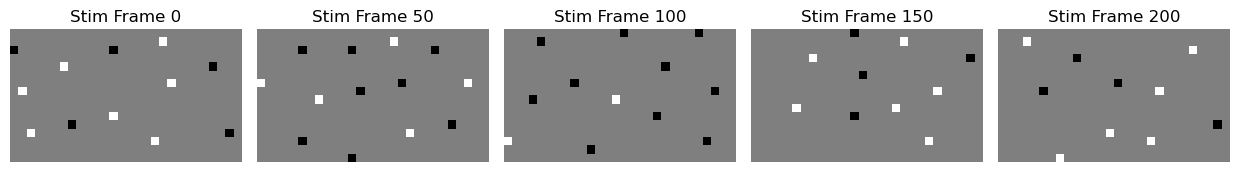

NameError: name 'HTML' is not defined

In [ ]:
from IPython.display import HTML
import utils as U
import importlib

importlib.reload(U)
# 0. Load the raw data
data = load_data()

# 1. Perform initial preprocessing (column renaming, time conversion)
# data = U.preprocess_data(data)

# 2. Filter the time-series data (dff, t, etc.) for the correct epochs
t_filtered, dff_filtered, running_speed_filtered = U.filter_timeseries_by_epoch(
    data, stimulus_name="locally_sparse_noise"
)

# 3. Filter the stimulus frames based on the new filtered time vector
stim_filtered, stim_table_filtered_df = U.filter_stimulus_data(data, t_filtered)

# # First, let's look at a few static frames again for context
U.plot_stim_frames(data, indices_to_display=[0, 50, 100, 150, 200])

# # Now, visualize the first 200 frames of the filtered stimulus as a movie
# # (Using a slice like [:200] makes the animation render faster)
HTML(U.visualize_stimulus_movie(stim_filtered[:200]).to_jshtml())

# What is the maximal activity projection?


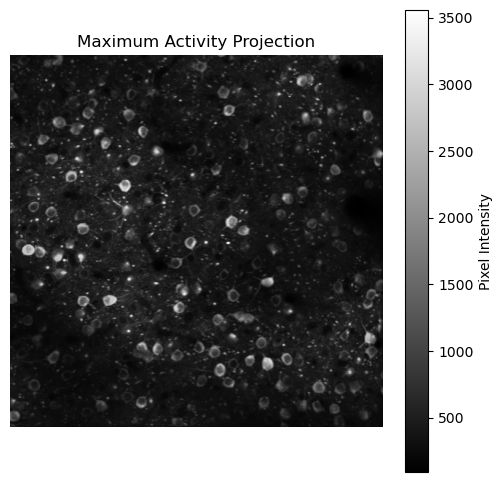

In [5]:
import importlib
import logging
import utils as U

importlib.reload(U)
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
# 2. Call the visualization functions
logging.info("\n--- Running Visualization Examples ---")
importlib.reload(U)

# Example 1: Plot max projection and show it on screen
U.plot_max_projection(data)